# Определение слов из аудио-файлов

Вам дан набор звуковых файлов в WAV формате. Каждый звуковой файл продолжительностью одна секунда где произносится ровно одно из 10 английских слов. Набор слов: ['cat', 'dog', 'five', 'four', 'house', 'one', 'six', 'stop', 'three', 'two'].

Ваша задача написать программу, которая автоматически определит какое именно слово произносится в звуковом файле.

В папке train лежат тренировочные файлы, разбитые по подпапкам. Именование папки совпадает со словом, которое произносится в звуковом файле. Название файлов имеет следующий формат словоIDчеловеканомер.

Замечание: люди, которые произносили слова в train и люди которые произносили слова в test различаются.

В файле sample_submission.csv приведен пример файла для отправки на сервер. Он содержит два поля id и answer. Вы должны вывести распознанное слово в поле answer (например 'cat').

In [1]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
with zipfile.ZipFile("/content/drive/MyDrive/Colab_Notebooks/data/sii_data/lab_4/miem-hse-ais-2023-lab-04.zip","r") as zip_ref:
    zip_ref.extractall("./")

In [3]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
from PIL import Image

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import os
import random
import IPython.display as ipd

# Путь к папке train
train_dir = 'train'

# Получаем список всех подпапок (классов) в папке train
classes = os.listdir(train_dir)

# Словарь для хранения пути к выбранному аудиофайлу из каждого класса
selected_files = {}

for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        # Получаем список всех аудиофайлов в подпапке
        audio_files = [f for f in os.listdir(class_dir) if f.endswith(('.wav', '.mp3', '.flac'))]
        if audio_files:
            # Выбираем случайный аудиофайл из списка
            selected_file = random.choice(audio_files)
            selected_files[class_name] = os.path.join(class_dir, selected_file)

# Воспроизводим выбранные аудиофайлы
for class_name, file_path in selected_files.items():
    print(f"Class: {class_name}")
    display(ipd.Audio(file_path))
    print("\n")

Class: house




Class: four




Class: cat




Class: three




Class: five




Class: six




Class: stop




Class: two




Class: dog




Class: one


Создадим универсальный класс датасета PyTorch из наших аудиофайлов. Метод getitem будет возвращать мел-спектрограмму аудиофайла для дальнейшего анализа. Сразу добавим возможности для трансформации и загрузки из csv.

In [6]:
class MyDataset(Dataset):
    def __init__(self, path, names, words, labels=None, transform=None, is_test=False, csv=None):
        self.names = names
        self.words = words
        self.labels = labels
        self.path = path
        self.transform = transform
        self.is_test = is_test
        self.data = pd.read_csv(csv)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        if self.is_test:
            waveform, sr = librosa.load(self.path + '/' + self.data.loc[index, 'id'])
            label = self.data.loc[index, 'answer']
        else:
            waveform, sr = librosa.load(f"{self.path}/{self.words[index]}/{self.names[index]}")
            label = self.labels[index]

        n_fft, step = 1024, 1024 // 4
        mel_spectrogram = librosa.power_to_db(librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=n_fft, hop_length=step), ref=np.max)
        mel_spectrogram = np.round(mel_spectrogram)
        mel_spectrogram = to_pil_image(mel_spectrogram)

        if self.transform is not None:
            mel_spectrogram = self.transform(mel_spectrogram)

        if self.labels is not None:
            return mel_spectrogram, label
        else:
            return mel_spectrogram

Преобразуем названия классов в числовые метки

In [7]:
def transformation(sounds_path, is_test=False):
    sounds_path = sorted(glob.glob(sounds_path))

    names, words, labels = [], [], []

    for path in sounds_path:
        if is_test:
            word = 'test'
            name = os.path.basename(path)
        else:
            word = os.path.basename(os.path.dirname(path))
            name = os.path.basename(path)
        words.append(word)
        names.append(name)

    if not is_test:
        for word in words:
            labels.append(word)

        label_dict = {'house': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'stop': 7, 'cat': 8, 'dog': 9}
        labels = [label_dict[label] for label in labels]

    return names, words, labels

Опишем методы PyTorch для тренировки, валидации и тестирования

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    loss_func = CrossEntropyLoss()
    model.train()
    total_loss = 0.0

    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data = data.repeat(1, 3, 1, 1).to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 40 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    return total_loss / len(train_loader)

def valid(model, device, valid_loader):
    print("Validation")
    loss_func = CrossEntropyLoss()
    model.eval()
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(valid_loader):
            data = data.repeat(1, 3, 1, 1).to(device)
            target = target.to(device)

            output = model(data)
            loss = loss_func(output, target)
            total_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(valid_loader.dataset)
    accuracy = correct / len(valid_loader.dataset) * 100.0

    return total_loss, accuracy


def test(model, device, test_loader):
    print("Test")
    model.eval()
    overall_output = []
    with torch.no_grad():
        for data in tqdm(test_loader):
            data = data.repeat(1, 3, 1, 1).to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            overall_output += list(pred.cpu().numpy()[:, 0])
    return overall_output

Опишем метод fit для обучения и валидации модели

In [9]:
def fit(model, train_loader, valid_loader, optimizer, scheduler, device, epochs):
    for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        valid_loss, accuracy = valid(model, device, valid_loader)

        print(f'Epoch {epoch}/{epochs} -> Train Loss: {train_loss:.6f} | Valid Loss: {valid_loss:.6f} | Accuracy: {accuracy:.2f}%')

        scheduler.step()

Подготовим данные для обучения - преобразуем спектрограммы к размеру 224 на 224 и сделаем их тензором, создадим датасет, разделим его на тренировочную, валидационную и тестовую части

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [11]:
train_names, train_words, train_labels = transformation('train/*/*.wav')
test_names, _, _ = transformation('test/*.wav', is_test=True)

train_dataset = MyDataset(path='train', names=train_names, words=train_words, labels=train_labels, transform=transform, csv='sample_submission.csv')

In [12]:
train_size = int(0.8 * len(train_dataset))
train_dataset, valid_dataset = random_split(train_dataset, [train_size, len(train_dataset) - train_size])

test_dataset = MyDataset(path='test', names=test_names, words=test_names, labels=None, transform=transform, is_test=True, csv='sample_submission.csv')

In [13]:
print(len(train_dataset+valid_dataset))

13147


Посмотрим на несколько спектрограмм

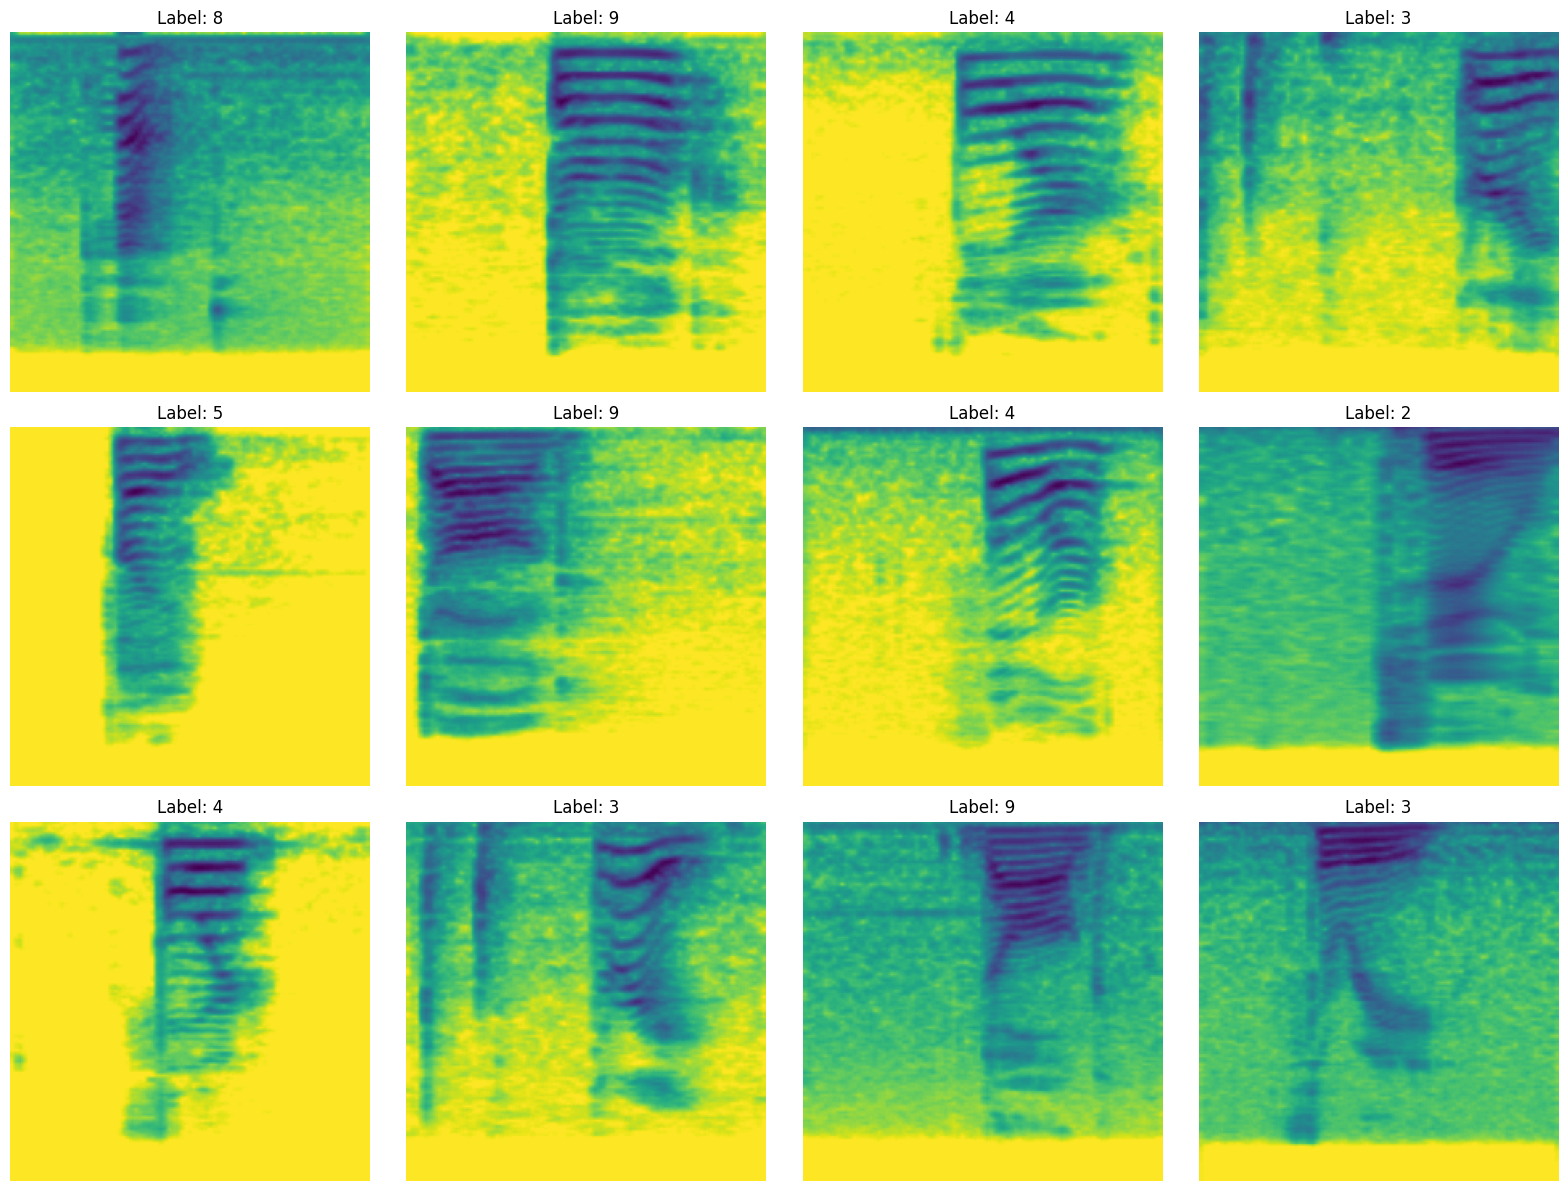

In [14]:
import matplotlib.pyplot as plt


# Создаем фигуру и оси для отображения изображений
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

# Пройдемся по первым 12 элементам датасета
for i in range(12):
    ax = axes[i // 4, i % 4]  # Определяем текущую ячейку в сетке
    train_example, train_label = train_dataset[i]
    ax.imshow(train_example.squeeze(), cmap='viridis')
    ax.set_title(f"Label: {train_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Создадим даталоадеры

In [15]:
batch_size = 64

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

Будем использовать предобученную модель EfficientNet-B3. Будем дообучать всю модель без замораживания весов. Примерная архитектура на картинке ниже

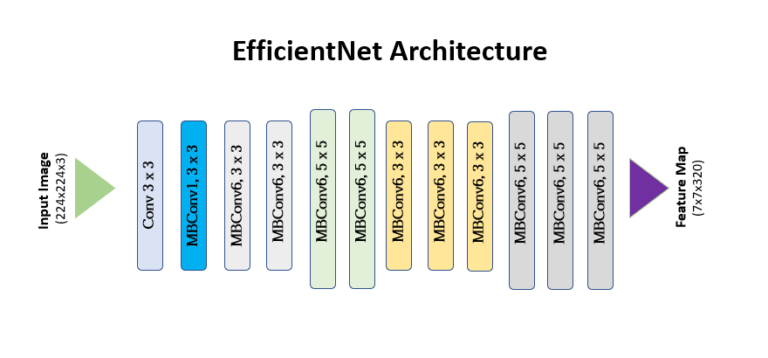

In [16]:
from torchvision.models import efficientnet_b3

model = efficientnet_b3(pretrained=True)

num_classes = 10
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

# Перемещение модели на GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 175MB/s]


Обучим модель

In [17]:
epochs = 3

fit(model, train_loader, valid_loader, optimizer, scheduler, device, epochs)

torch.save(model.state_dict(), "my_model.pt")

output = test(model, device, test_loader)

1it [00:02,  2.40s/it]

Train Epoch: 1 [0/10517 (0%)]	Loss: 2.357240


41it [00:51,  1.10s/it]

Train Epoch: 1 [2560/10517 (24%)]	Loss: 0.249407


81it [01:39,  1.15s/it]

Train Epoch: 1 [5120/10517 (48%)]	Loss: 0.198297


121it [02:29,  1.35s/it]

Train Epoch: 1 [7680/10517 (73%)]	Loss: 0.272038


161it [03:19,  1.34s/it]

Train Epoch: 1 [10240/10517 (97%)]	Loss: 0.068069


165it [03:22,  1.23s/it]


Validation


100%|██████████| 42/42 [00:31<00:00,  1.31it/s]


Epoch 1/3 -> Train Loss: 0.411888 | Valid Loss: 0.001557 | Accuracy: 96.88%


1it [00:01,  1.07s/it]

Train Epoch: 2 [0/10517 (0%)]	Loss: 0.055220


41it [00:50,  1.12s/it]

Train Epoch: 2 [2560/10517 (24%)]	Loss: 0.039231


81it [01:38,  1.12s/it]

Train Epoch: 2 [5120/10517 (48%)]	Loss: 0.022567


121it [02:27,  1.29s/it]

Train Epoch: 2 [7680/10517 (73%)]	Loss: 0.181227


161it [03:16,  1.45s/it]

Train Epoch: 2 [10240/10517 (97%)]	Loss: 0.105672


165it [03:20,  1.21s/it]


Validation


100%|██████████| 42/42 [00:31<00:00,  1.33it/s]


Epoch 2/3 -> Train Loss: 0.062323 | Valid Loss: 0.001133 | Accuracy: 97.87%


1it [00:01,  1.08s/it]

Train Epoch: 3 [0/10517 (0%)]	Loss: 0.003391


41it [00:49,  1.16s/it]

Train Epoch: 3 [2560/10517 (24%)]	Loss: 0.002670


81it [01:37,  1.11s/it]

Train Epoch: 3 [5120/10517 (48%)]	Loss: 0.096848


121it [02:26,  1.11s/it]

Train Epoch: 3 [7680/10517 (73%)]	Loss: 0.074233


161it [03:15,  1.28s/it]

Train Epoch: 3 [10240/10517 (97%)]	Loss: 0.003685


165it [03:19,  1.21s/it]


Validation


100%|██████████| 42/42 [00:31<00:00,  1.34it/s]


Epoch 3/3 -> Train Loss: 0.035708 | Valid Loss: 0.001040 | Accuracy: 97.95%
Test


100%|██████████| 142/142 [01:53<00:00,  1.25it/s]


Итоговая точность (accuracy) на валидации составляет 97,95%. Задача выполнена, классификация работает очень хорошо.

In [18]:
label_mapping = {0: 'house', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'stop', 8: 'cat', 9: 'dog'}
output_words = [label_mapping[int(label)] for label in output]

sam_sub = pd.read_csv('sample_submission.csv')
submission = pd.DataFrame(sam_sub['id'], columns=['id'])
submission['answer'] = output_words
submission.to_csv('gorbuntsov_result.csv', index=False)